In [1]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import prod

In [ ]:
# Read stock data
data = pd.read_csv("Full dataset.csv")
data['date'] = pd.to_datetime(data['date'])
data.rename(columns={'PERMNO': 'Permno'}, inplace=True)
data['date'] = data['date'] + pd.offsets.MonthEnd(0)
data['MktCap'] = data['PRC'] * data['SHROUT']

# Check for duplicates and remove if found
duplicates = data.groupby(['date', 'Permno']).size().reset_index(name='count')
duplicates = duplicates[duplicates['count'] > 1]

if not duplicates.empty:
  print("Found duplicate entries:")
  print(duplicates)

  returns = data.groupby(['date', 'Permno'])['RET'].mean().reset_index()

# Pivot stock data to returns dataframe
returns = data.pivot(index='date', columns='Permno', values='RET')
returns = returns.applymap(lambda x: pd.to_numeric(x, errors='coerce'))

# Display returns.head
returns.head()

Permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93427,93428,93429,93430,93431,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1973-01-31,NaN,NaN,NaN,NaN,NaN,-0.060367,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-02-28,NaN,NaN,NaN,NaN,NaN,-0.075978,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-03-31,NaN,NaN,NaN,NaN,NaN,0.110429,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-04-30,NaN,NaN,NaN,NaN,NaN,-0.002762,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-05-31,NaN,NaN,NaN,NaN,NaN,-0.011634,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Read three factor file 
three_factors = pd.read_csv("Fama French 3 Factors.csv")
three_factors.columns = three_factors.iloc[2]
three_factors = three_factors.iloc[3:1181]
three_factors.rename(columns={three_factors.columns[0]: 'Date'}, inplace = True)
three_factors['Date'] = pd.to_datetime(three_factors['Date'], format = '%Y%m') + pd.offsets.MonthEnd(0)

# Read five factor file
five_factors = pd.read_csv("Fama French 5 Factors.csv")
five_factors.columns = five_factors.iloc[2]
five_factors = five_factors.iloc[3:737]
five_factors.rename(columns={five_factors.columns[0]: 'Date'}, inplace = True)
five_factors['Date'] = pd.to_datetime(five_factors['Date'], format = '%Y%m') + pd.offsets.MonthEnd(0)

# Read momentum factor file 
Mom_factor = pd.read_csv("Fama French Momentum Factor.csv")
Mom_factor = Mom_factor.iloc[:1172]
Mom_factor['Date'] = pd.to_datetime(Mom_factor['Date'], format = '%Y%m') + pd.offsets.MonthEnd(0)

# Merge factors into one dataframe
factors = pd.merge(three_factors[['Date', 'Mkt-RF', 'SMB', 'HML']], Mom_factor[['Date', 'MOM']], on='Date')
factors = pd.merge(factors, five_factors[['Date', 'RMW', 'CMA', 'RF']], on='Date')
factors = factors.loc[(factors['Date'] >= pd.to_datetime('1973-01')) & (factors['Date'] <= pd.to_datetime('2024-01'))]
factors.set_index('Date', inplace = True)
factors = factors.astype(float)
factors /= 100

# Display factors.head
factors.head()

,Mkt-RF,SMB,HML,MOM,RMW,CMA,RF
Date,,,,,,,
1973-01-31,-0.0329,-0.0349,0.0268,0.0373,0.0042,0.0090,0.0044
1973-02-28,-0.0485,-0.0387,0.0160,0.0216,-0.0026,0.0002,0.0041
1973-03-31,-0.0130,-0.0282,0.0262,0.0359,-0.0107,0.0062,0.0046
1973-04-30,-0.0568,-0.0385,0.0541,0.0636,-0.0158,0.0260,0.0052
1973-05-31,-0.0294,-0.0630,0.0041,0.0714,0.0195,-0.0157,0.0051


In [4]:
# Create copy for excess returns
excess_returns = returns.copy()

# Subtract RF from all columns
excess_returns = excess_returns.sub(factors['RF'], axis=0)

# Fill na
excess_returns[returns.isna()] = returns[returns.isna()]

# Display excess_returns.head
excess_returns.head()

Permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93427,93428,93429,93430,93431,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1973-01-31,NaN,NaN,NaN,NaN,NaN,-0.064767,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-02-28,NaN,NaN,NaN,NaN,NaN,-0.080078,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-03-31,NaN,NaN,NaN,NaN,NaN,0.105829,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-04-30,NaN,NaN,NaN,NaN,NaN,-0.007962,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-05-31,NaN,NaN,NaN,NaN,NaN,-0.016734,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Function to calculate deciles thresholds from 0 to 90
def calculate_deciles(data):
  deciles = []
  for i in range(0, 91, 10):
    decile = np.percentile(data, i)
    deciles.append(decile)
  return deciles

# Function to average the innermost values of nested lists, used to calculate average returns of group of stocks
def average_innermost_lists(nested_lists):

    if not isinstance(nested_lists, list):
        return nested_lists

    # Check if we're at the innermost list (contains numbers)
    if nested_lists and not isinstance(nested_lists[0], list):
        return np.mean(nested_lists)

    # Recursively process nested lists
    return [average_innermost_lists(sublist) for sublist in nested_lists]



In [48]:
# Initialize date window for regressions
window_start = pd.to_datetime('1973-01-31')
window_end = window_start + pd.DateOffset(years=5) - pd.offsets.MonthEnd(1)
final_date = pd.to_datetime(returns.index[-1])

date_index = pd.date_range(start=window_end + pd.offsets.MonthEnd(1), end=final_date, freq='M')

# Initialize lists to store decile returns
decile_returns = []

# Select factor to analyze
factor = 'Mkt-RF'

# Run regressions with monthly frequency
while window_end < final_date:

  # Get top 500 assets at the end of each calendar year
  next_year = window_end + pd.DateOffset(years=1)
  df_date = data[data['date'] == window_end]
  top_assets = df_date.sort_values('MktCap', ascending = False).head(500)
  permnos = top_assets['Permno'].tolist()

  # Monthly loop
  while window_end < next_year and window_end < final_date:

    # Initialize lists to store decile buckets and beta+returns for month
    decile_returns_row = [[] for i in range(10)]
    betas_returns = []

    # Iterate through assets
    for permno in permnos:

      # Filter data by regression window
      filtered_returns = excess_returns.loc[window_start:window_end]
      filtered_factors = factors.loc[window_start:window_end]

      # Run regression
      if filtered_returns[permno].notnull().sum() / len(filtered_returns )> 0.5 and filtered_returns[permno][-12:].notnull().all(): # at least 50% of returns, most recent year filled
        regression = sm.OLS(filtered_returns[permno], sm.add_constant(filtered_factors[factor]),missing='drop').fit() # Calculate speficied factor beta
        beta = regression.params[factor] # Get beta
        next_month_excess_return = excess_returns.loc[window_end + pd.offsets.MonthEnd(1), permno] # Get next month excess return of that asset

        # Store beta and next month excess return pair into list if next month return is not NaN
        if not np.isnan(next_month_excess_return):
          br_entry = [beta, next_month_excess_return]
          betas_returns.append(br_entry)

    # Calculate beta decile thresholds
    betas = [item[0] for item in betas_returns]
    deciles = calculate_deciles(betas)

    # Iterate through beta+returns pairs and append next month returns to corresponding decile bucket
    for i in range(len(betas_returns)):
      for d in range(9, -1, -1): # Iterate backwards from high beta decile to low beta decile
        if betas_returns[i][0] >= deciles[d]: # If beta is greater than or equal to decile threshold
          decile_returns_row[9-d].append(betas_returns[i][1]) # Append next month return to corresponding decile bucket, where decile 0 is the highest beta decile and decile 9 is the lowest beta decile
          break

    decile_returns_row = average_innermost_lists(decile_returns_row) # Calculate average excess next month returns for each decile
    decile_returns.append(decile_returns_row) # Append decile returns to list

    # Increment dates by one month
    window_start += pd.offsets.MonthEnd(1)
    window_end += pd.offsets.MonthEnd(1)


decile_returnsdf = pd.DataFrame(decile_returns, columns = [i for i in range(1, 11)], index = date_index) # Convert nested decile returns list to dataframe
decile_returnsdf.head() 

,1,2,3,4,5,6,7,8,9,10
1978-01-31,-0.074254,-0.083919,-0.069233,-0.053136,-0.067409,-0.057442,-0.053406,-0.054847,-0.052661,-0.054934
1978-02-28,-0.010512,-0.007315,-0.032061,-0.025018,-0.022527,-0.027227,-0.021302,-0.011188,-0.018669,-0.020241
1978-03-31,0.057202,0.049496,0.040171,0.028650,0.031935,0.042393,0.040248,0.013822,0.023536,0.036833
1978-04-30,0.102692,0.105850,0.113648,0.095375,0.067657,0.067319,0.053850,0.063512,0.032085,0.028132
1978-05-31,0.040081,0.018802,0.018346,0.030828,0.028319,0.038712,0.026857,0.019236,-0.001565,0.011960


In [87]:
# Initialize regression window
regression_start = pd.to_datetime('1978-01-31')
regression_end = pd.to_datetime(decile_returnsdf.index[-1])

# Initialize empty factor neutral decile returns dataframe and lists to store data
factor_neutral_decile_returnsdf = pd.DataFrame(columns = [i for i in range(1, 11)], index = decile_returnsdf.index)
alphas = [[] for i in range(10)]
factor_betas = [[] for i in range(10)]
r_squared = [[] for i in range(10)]

# Iterate through each decile's returns
for i in range(10):

  # Initialize lists to store betas
  factor_beta_entries = []

  # Filter factor data
  filtered_factors = factors.loc[regression_start:regression_end, ['Mkt-RF']] # CAPM specification
  # filtered_factors = factors.loc[regression_start:regression_end, ['Mkt-RF', 'SMB', 'HML']] # 3-Factor specification
  # filtered_factors = factors.loc[regression_start:regression_end, ['Mkt-RF', 'SMB', 'HML', 'MOM']] # 4-Factor specification
  # filtered_factors = factors.loc[regression_start:regression_end, ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']] # 5-Factor specification

  regression = sm.OLS(decile_returnsdf[i+1], sm.add_constant(filtered_factors), missing='drop').fit() # Run regression

  mkt_beta = regression.params['Mkt-RF'] # Assign beta value
  # smb_beta = regression.params['SMB'] # Add if necessary
  # hml_beta = regression.params['HML']
  # mom_beta = regression.params['MOM']
  # rmw_beta = regression.params['RMW']
  # cma_beta = regression.params['CMA']
  r_squared[i] = regression.rsquared # Store R-squared value
  alphas[i] = regression.params['const'] # Store alpha value

  # Append factor betas to list
  factor_beta_entries.append(mkt_beta)
  # factor_beta_entries.append(smb_beta) # Add if necessary
  # factor_beta_entries.append(hml_beta)
  # factor_beta_entries.append(mom_beta)
  # factor_beta_entries.append(rmw_beta)
  # factor_beta_entries.append(cma_beta)

  # Calculate factor neutral decile returns equal to alpha of regression
  factor_neutral_decile_returnsdf[i+1] = decile_returnsdf[i+1] - mkt_beta * filtered_factors['Mkt-RF'] # CAPM specification
  # factor_neutral_decile_returnsdf[i+1] = decile_returnsdf[i+1] - mkt_beta * filtered_factors['Mkt-RF'] - smb_beta * filtered_factors['SMB'] - hml_beta * filtered_factors['HML'] # 3-Factor specification
  # factor_neutral_decile_returnsdf[i+1] = decile_returnsdf[i+1] - mkt_beta * filtered_factors['Mkt-RF'] - smb_beta * filtered_factors['SMB'] - hml_beta * filtered_factors['HML'] - mom_beta * filtered_factors['MOM'] # 4-Factor specification
  # factor_neutral_decile_returnsdf[i+1] = decile_returnsdf[i+1] - mkt_beta * filtered_factors['Mkt-RF'] - smb_beta * filtered_factors['SMB'] - hml_beta * filtered_factors['HML'] - rmw_beta * filtered_factors['RMW'] - cma_beta * filtered_factors['CMA'] # 5-Factor specification
  
  # Append factor betas to list
  factor_betas[i] = factor_beta_entries

# Convert r_squared list to dataframe
r_squareddf = pd.DataFrame(r_squared).T
r_squareddf.columns = [i for i in range(1, 11)]

# Convert alphas list to dataframe
alphasdf = pd.DataFrame(alphas).T
alphasdf.columns = [i for i in range(1, 11)]

# Convert factor_betas list to dataframe 
factor_betasdf = pd.DataFrame(factor_betas).T
factor_betasdf.columns = [i for i in range(1, 11)]

In [88]:
factor_betasdf

,1,2,3,4,5,6,7,8,9,10
0,1.649365,1.370281,1.235534,1.103792,1.018497,0.94067,0.868271,0.761902,0.629689,0.441138


In [89]:
r_squareddf

,1,2,3,4,5,6,7,8,9,10
0,0.759738,0.858607,0.895521,0.89411,0.898092,0.85766,0.835083,0.765423,0.664731,0.371066


In [90]:
# Calculate average factor neutral returns for each decile
returns_avg = pd.DataFrame([factor_neutral_decile_returnsdf.mean()])
returns_avg

,1,2,3,4,5,6,7,8,9,10
0,-0.003912,-0.003182,-0.001801,0.000253,0.000805,0.000882,0.001611,0.003236,0.002394,0.002342


In [91]:
alphasdf

,1,2,3,4,5,6,7,8,9,10
0,-0.003912,-0.003182,-0.001801,0.000253,0.000805,0.000882,0.001611,0.003236,0.002394,0.002342


Text(0, 0.5, 'Alphas')

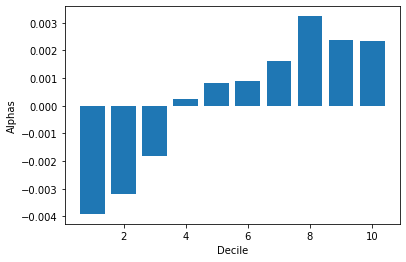

In [92]:
plt.bar(alphasdf.columns, alphasdf.iloc[0])
plt.xlabel('Decile')
plt.ylabel('Alphas')

In [93]:
# Initialize list to store all performance metrics
performance_metrics = []

# Iterate through each decile and calculate performance metrics
for i in range(10):

  # Initialize list to store performance metrics for each decile  
  entry = []
  monthly_arithmetic_mean = factor_neutral_decile_returnsdf[i+1].mean() # Calculate monthly arithmetic mean
  annual_arithmetic_mean = monthly_arithmetic_mean * 12 # Calculate annual arithmetic mean
  monthly_volatility = factor_neutral_decile_returnsdf[i+1].std() # Calculate monthly volatility
  annual_volatility = monthly_volatility * np.sqrt(12) # Calculate annual volatility
  monthly_geometric_mean = (1 + factor_neutral_decile_returnsdf[i+1]).prod() ** (1/len(factor_neutral_decile_returnsdf)) - 1 # Calculate monthly geometric mean
  annual_geometric_mean = (1 + monthly_geometric_mean) ** 12 - 1 # Calculate annual geometric mean
  sharpe_ratio = annual_arithmetic_mean / annual_volatility # Calculate Sharpe ratio
  t_stat = (np.sqrt(len(factor_neutral_decile_returnsdf)) * sharpe_ratio) / np.sqrt(12) # Calculate t-statistic

  # Append performance metrics to list
  entry.append(annual_arithmetic_mean)
  entry.append(t_stat)
  entry.append(annual_geometric_mean)
  entry.append(annual_volatility)
  entry.append(sharpe_ratio)
  performance_metrics.append(entry)

index = [i for i in range(1,11)] # Assign index values for deciles
columns = ['Arithmetic Mean', 't-stat', 'Geometric Mean', 'Volatility', 'Sharpe Ratio'] # Assign column names for performance metrics
performance_metricsdf = pd.DataFrame(performance_metrics, columns = columns, index = index).T # Convert performance metrics list to dataframe
performance_metricsdf


,1,2,3,4,5,6,7,8,9,10
Arithmetic Mean,-0.046944,-0.038189,-0.021608,0.003030,0.009656,0.010582,0.019330,0.038829,0.028733,0.028103
t-stat,-2.177317,-2.954493,-2.202658,0.343160,1.210749,1.187890,2.155167,3.960335,2.764080,2.105100
Geometric Mean,-0.055809,-0.041195,-0.023556,0.001245,0.008221,0.008786,0.017629,0.037242,0.026582,0.024269
Volatility,0.146230,0.087667,0.066534,0.059886,0.054089,0.060416,0.060832,0.066497,0.070503,0.090544
Sharpe Ratio,-0.321028,-0.435616,-0.324764,0.050596,0.178515,0.175145,0.317762,0.583919,0.407541,0.310380


In [94]:
# Create betting against beta portfolio that goes long the lowest beta decile and short the highest beta decile
betting_against_betadf = pd.DataFrame(factor_neutral_decile_returnsdf[10] - factor_neutral_decile_returnsdf[1], columns=['BAB Return'])

# Calculate performance metrics for betting against beta portfolio
monthly_arithmetic_mean = betting_against_betadf['BAB Return'].mean() # Calculate monthly arithmetic mean
annual_arithmetic_mean = monthly_arithmetic_mean * 12 # Calculate annual arithmetic mean
monthly_volatility = betting_against_betadf['BAB Return'].std() # Calculate monthly volatility
annual_volatility = monthly_volatility * np.sqrt(12) # Calculate annual volatility
monthly_geometric_mean = (1 + betting_against_betadf['BAB Return']).prod() ** (1/len(factor_neutral_decile_returnsdf)) - 1 # Calculate monthly geometric mean
annual_geometric_mean = (1 + monthly_geometric_mean) ** 12 - 1 # Calculate annual geometric mean
sharpe_ratio = annual_arithmetic_mean / annual_volatility # Calculate Sharpe ratio
t_stat = (np.sqrt(len(factor_neutral_decile_returnsdf)) * sharpe_ratio) / np.sqrt(12) # Calculate t-statistic
correlation_coefficient = performance_metricsdf.loc['Arithmetic Mean', performance_metricsdf.columns].astype(float).corr(pd.Series([10,9,8,7,6,5,4,3,2,1]))
print('Arithmetic Mean: ', annual_arithmetic_mean)
print('t-stat: ', t_stat)
print('Geometric Mean: ', annual_geometric_mean)
print('Volatility: ', annual_volatility)
print('Sharpe Ratio: ', sharpe_ratio)
print('Correlation Coefficient: ', correlation_coefficient)

Arithmetic Mean:  0.07504683883689159
t-stat:  2.5275649113234215
Geometric Mean:  0.05522622381969655
Volatility:  0.2013765988370655
Sharpe Ratio:  0.3726691148340044
Correlation Coefficient:  -0.9582505048342788
